## 📦 Step 1: Importar Librerías

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
import pandas as pd
import random
import librosa
import soundfile as sf
from IPython.display import Audio, display

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

print("✅ Librerías importadas")
print(f"PyTorch versión: {torch.__version__}")

# Configurar dispositivo
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"🖥️  Dispositivo: {device}")

✅ Librerías importadas
PyTorch versión: 2.9.1
🖥️  Dispositivo: mps


## ⚙️ Step 2: Configuración y Rutas

In [14]:
# Rutas
DATA_DIR = Path("../data")
MODELS_DIR = Path("../models")
OUTPUT_DIR = Path("../results")
OUTPUT_DIR.mkdir(exist_ok=True)

# Modelo pre-entrenado sintético (CnnModel2)
SYNTH_MODEL_PATH = Path("../../Models/CnnModel2/models_multifactor/best_model_upsample5x.pth")

# Modelos entrenados con audio
REAL_MODEL_PATH = MODELS_DIR / "timeseries_srnet_audio_real.pth"
MIXED_MODEL_PATH = MODELS_DIR / "timeseries_srnet_audio_mixed.pth"
TUNNED_MODEL_PATH = MODELS_DIR / "timeseries_srnet_audio_tunned.pth"

# Parámetros
INPUT_SIZE = 1000
OUTPUT_SIZE = 5000
UPSAMPLE_FACTOR = 5

print("="*60)
print("RUTAS DE MODELOS")
print("="*60)
print(f"📁 Synth:  {SYNTH_MODEL_PATH} - Existe: {SYNTH_MODEL_PATH.exists()}")
print(f"📁 Real:   {REAL_MODEL_PATH} - Existe: {REAL_MODEL_PATH.exists()}")
print(f"📁 Mixed:  {MIXED_MODEL_PATH} - Existe: {MIXED_MODEL_PATH.exists()}")
print(f"📁 Tunned: {TUNNED_MODEL_PATH} - Existe: {TUNNED_MODEL_PATH.exists()}")
print("="*60)

RUTAS DE MODELOS
📁 Synth:  ../../Models/CnnModel2/models_multifactor/best_model_upsample5x.pth - Existe: True
📁 Real:   ../models/timeseries_srnet_audio_real.pth - Existe: True
📁 Mixed:  ../models/timeseries_srnet_audio_mixed.pth - Existe: True
📁 Tunned: ../models/timeseries_srnet_audio_tunned.pth - Existe: True


## 🏗️ Step 3: Definir Arquitecturas

In [15]:
# Versión SIN BatchNorm (para Real y Mixed)
class TimeSeriesSRNet(nn.Module):
    def __init__(self, upsample_factor=5):
        super(TimeSeriesSRNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
        )
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=upsample_factor, mode='linear', align_corners=True),
            nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 1, kernel_size=9, stride=1, padding=4)
        )
    
    def forward(self, x):
        return self.upsample(self.encoder(x))


# Versión CON BatchNorm (para Synth y Tunned)
class TimeSeriesSRNetBN(nn.Module):
    def __init__(self, input_size=1000, output_size=5000):
        super(TimeSeriesSRNetBN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
        )
        self.upsample = nn.Sequential(
            nn.Upsample(size=output_size, mode='linear', align_corners=True),
            nn.Conv1d(256, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Conv1d(64, 1, kernel_size=9, stride=1, padding=4)
        )
    
    def forward(self, x):
        return self.upsample(self.encoder(x))


print("✅ Arquitecturas definidas")

✅ Arquitecturas definidas


## 📥 Step 4: Cargar Modelos

In [16]:
def load_model_bn(path, device):
    """Carga modelo CON BatchNorm."""
    model = TimeSeriesSRNetBN(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE)
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    return model


def load_model_no_bn(path, device):
    """Carga modelo SIN BatchNorm."""
    model = TimeSeriesSRNet(upsample_factor=UPSAMPLE_FACTOR)
    model.load_state_dict(torch.load(path, map_location=device, weights_only=False))
    model.to(device)
    model.eval()
    return model


# Cargar los 4 modelos
models = {}

if SYNTH_MODEL_PATH.exists():
    models['Synth'] = load_model_bn(SYNTH_MODEL_PATH, device)
    print("✅ Modelo Synth cargado")

if REAL_MODEL_PATH.exists():
    models['Real-Audio'] = load_model_no_bn(REAL_MODEL_PATH, device)
    print("✅ Modelo Real-Audio cargado")

if MIXED_MODEL_PATH.exists():
    models['Mixed-Audio'] = load_model_no_bn(MIXED_MODEL_PATH, device)
    print("✅ Modelo Mixed-Audio cargado")

if TUNNED_MODEL_PATH.exists():
    models['Tunned-Audio'] = load_model_bn(TUNNED_MODEL_PATH, device)
    print("✅ Modelo Tunned-Audio cargado")

print(f"\n📊 Total modelos cargados: {len(models)}")

✅ Modelo Synth cargado
✅ Modelo Real-Audio cargado
✅ Modelo Mixed-Audio cargado
✅ Modelo Tunned-Audio cargado

📊 Total modelos cargados: 4


## 📥 Step 5: Cargar Datos de Test

In [17]:
training_dir = DATA_DIR / "training"

x_test = np.loadtxt(training_dir / "x_audio_test.txt")
y_test = np.loadtxt(training_dir / "y_audio_test.txt")

print(f"📊 Datos de test cargados:")
print(f"   x_test: {x_test.shape}")
print(f"   y_test: {y_test.shape}")

📊 Datos de test cargados:
   x_test: (125, 1000)
   y_test: (125, 5000)


## 📊 Step 6: Funciones de Evaluación

In [18]:
def predict(model, x_data, device):
    """Genera predicciones con el modelo."""
    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(x_data[:, np.newaxis, :], dtype=torch.float32).to(device)
        y_pred = model(x_tensor)
    return y_pred.cpu().numpy().squeeze()


def calculate_metrics(y_true, y_pred):
    """Calcula métricas de evaluación."""
    mae = np.mean(np.abs(y_true - y_pred))
    mse = np.mean((y_true - y_pred)**2)
    rmse = np.sqrt(mse)
    
    # Correlación promedio
    correlations = []
    for i in range(len(y_true)):
        corr, _ = pearsonr(y_true[i], y_pred[i])
        if not np.isnan(corr):
            correlations.append(corr)
    mean_corr = np.mean(correlations) if correlations else 0
    
    # SNR
    signal_power = np.mean(y_true**2)
    noise_power = np.mean((y_true - y_pred)**2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'Correlation': mean_corr,
        'SNR (dB)': snr
    }


print("✅ Funciones de evaluación definidas")

✅ Funciones de evaluación definidas


## 📊 Step 7: Evaluar Todos los Modelos

In [19]:
# Evaluar cada modelo
results = {}
predictions = {}

print("="*70)
print("EVALUACIÓN DE MODELOS")
print("="*70)

for name, model in models.items():
    print(f"\n🔄 Evaluando {name}...")
    y_pred = predict(model, x_test, device)
    predictions[name] = y_pred
    
    metrics = calculate_metrics(y_test, y_pred)
    results[name] = metrics
    
    print(f"   MAE: {metrics['MAE']:.6f}")
    print(f"   Correlation: {metrics['Correlation']:.6f}")
    print(f"   SNR: {metrics['SNR (dB)']:.2f} dB")

print("\n" + "="*70)

EVALUACIÓN DE MODELOS

🔄 Evaluando Synth...
   MAE: 0.067937
   Correlation: 0.857009
   SNR: -0.04 dB

🔄 Evaluando Real-Audio...
   MAE: 0.003972
   Correlation: 0.956439
   SNR: 17.27 dB

🔄 Evaluando Mixed-Audio...
   MAE: 0.005023
   Correlation: 0.948130
   SNR: 16.07 dB

🔄 Evaluando Tunned-Audio...
   MAE: 0.015231
   Correlation: 0.757508
   SNR: 9.32 dB



## 📊 Step 8: Tabla Comparativa

In [20]:
# Crear DataFrame con resultados
df_results = pd.DataFrame(results).T
df_results = df_results.round(6)

print("="*70)
print("TABLA COMPARATIVA DE RESULTADOS")
print("="*70)
print(df_results.to_string())
print("="*70)

# Guardar resultados
df_results.to_csv(OUTPUT_DIR / "model_comparison_audio.csv")
print(f"\n💾 Resultados guardados en {OUTPUT_DIR / 'model_comparison_audio.csv'}")

TABLA COMPARATIVA DE RESULTADOS
                   MAE       MSE      RMSE  Correlation   SNR (dB)
Synth         0.067937  0.005232  0.072333     0.857009  -0.041811
Real-Audio    0.003972  0.000097  0.009857     0.956439  17.269658
Mixed-Audio   0.005023  0.000128  0.011324     0.948130  16.065212
Tunned-Audio  0.015231  0.000606  0.024626     0.757508   9.316930

💾 Resultados guardados en ../results/model_comparison_audio.csv


## 📊 Step 9: Gráficos Comparativos

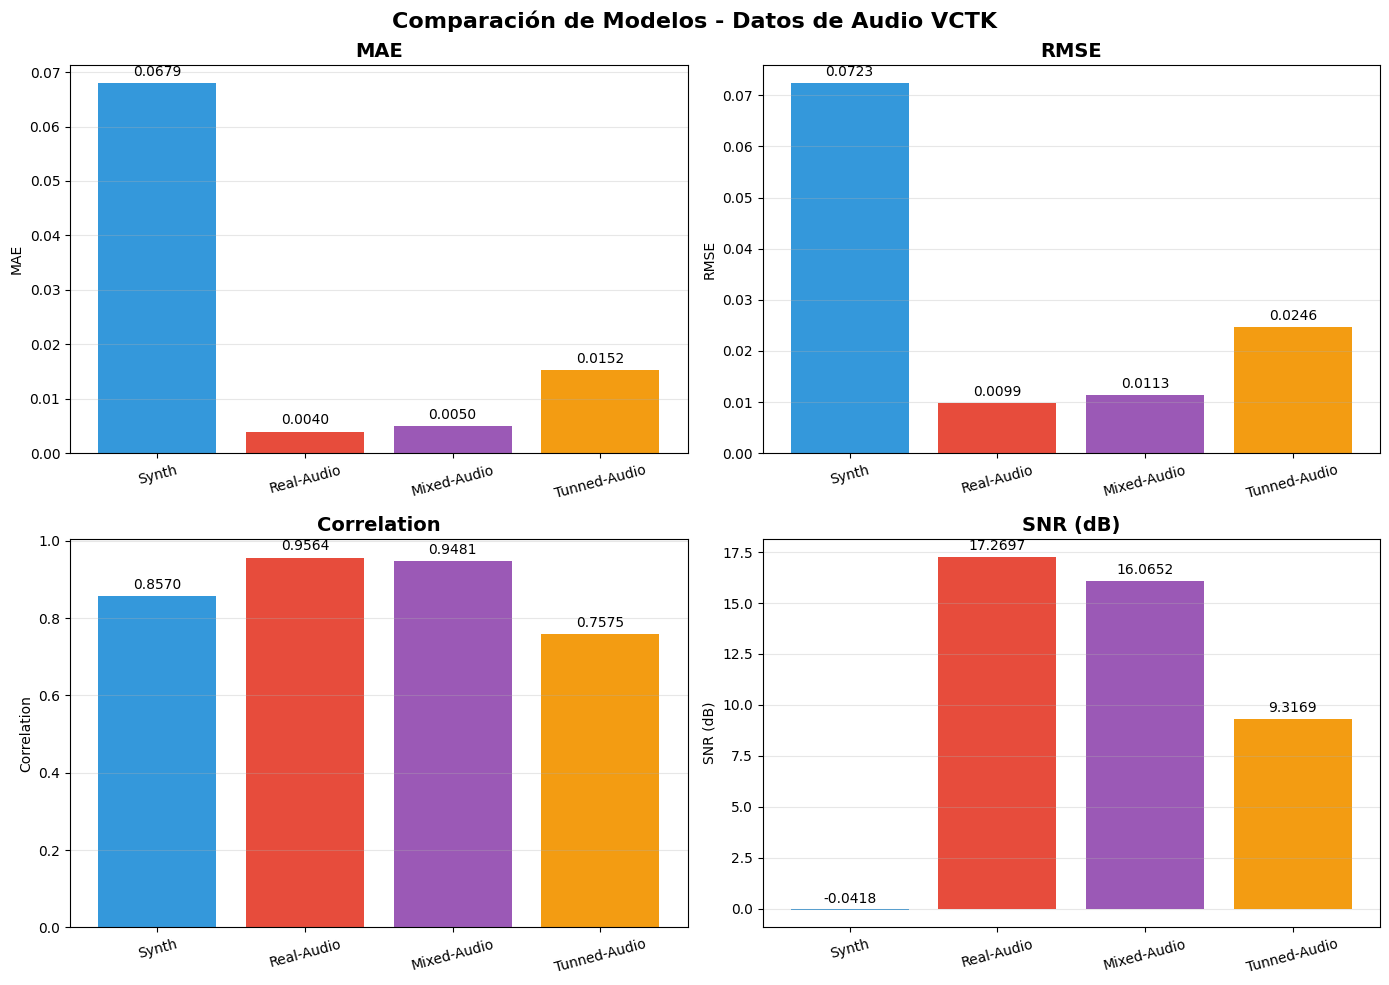


💾 Gráfico guardado en ../results/metrics_comparison_audio.png


In [21]:
# Gráfico de barras para métricas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['MAE', 'RMSE', 'Correlation', 'SNR (dB)']
colors = ['#3498db', '#e74c3c', '#9b59b6', '#f39c12']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    values = [results[model][metric] for model in results.keys()]
    bars = ax.bar(list(results.keys()), values, color=colors)
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=15)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Añadir valores en las barras
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{val:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.suptitle('Comparación de Modelos - Datos de Audio VCTK', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "metrics_comparison_audio.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Gráfico guardado en {OUTPUT_DIR / 'metrics_comparison_audio.png'}")

## 📊 Step 10: Visualizar Predicciones por Modelo

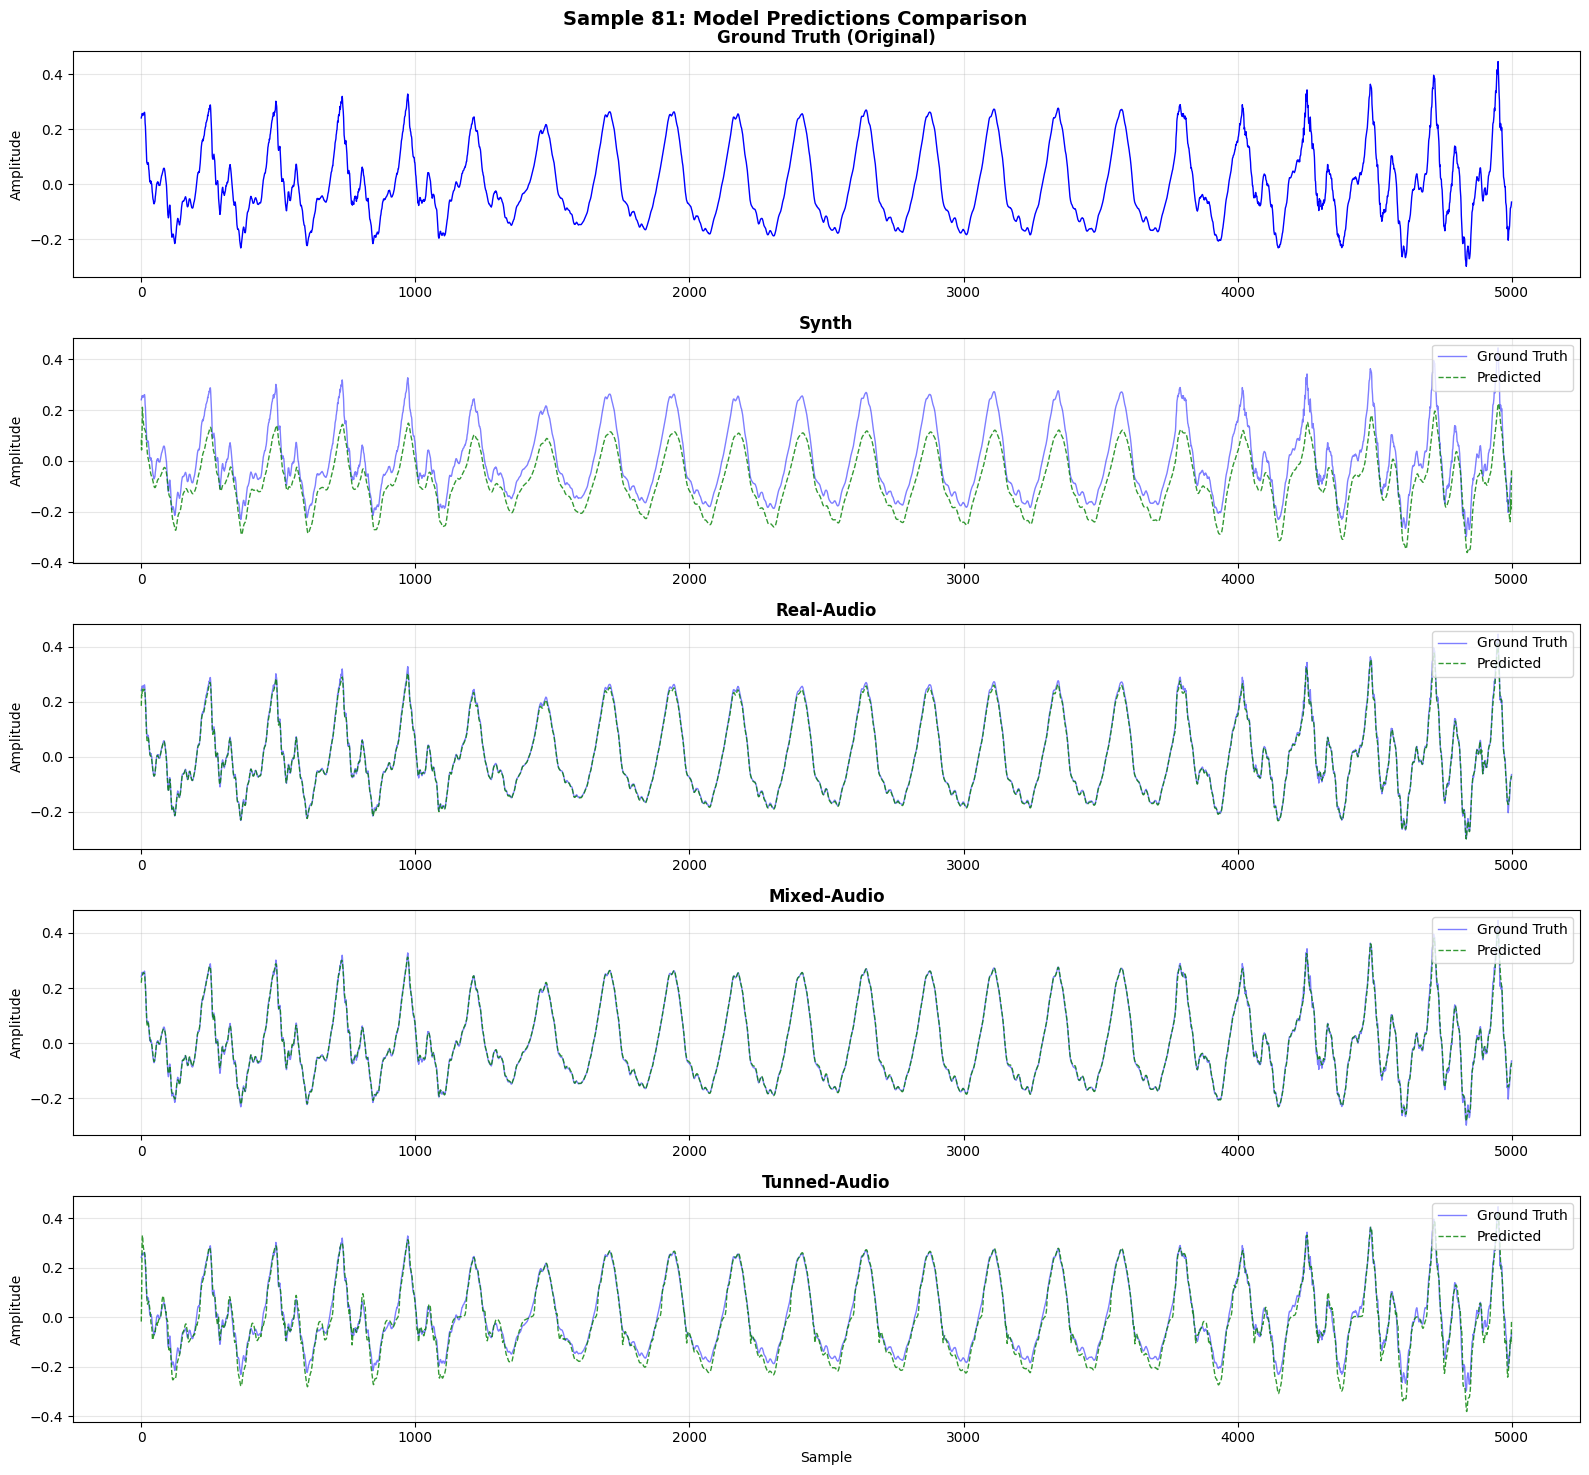

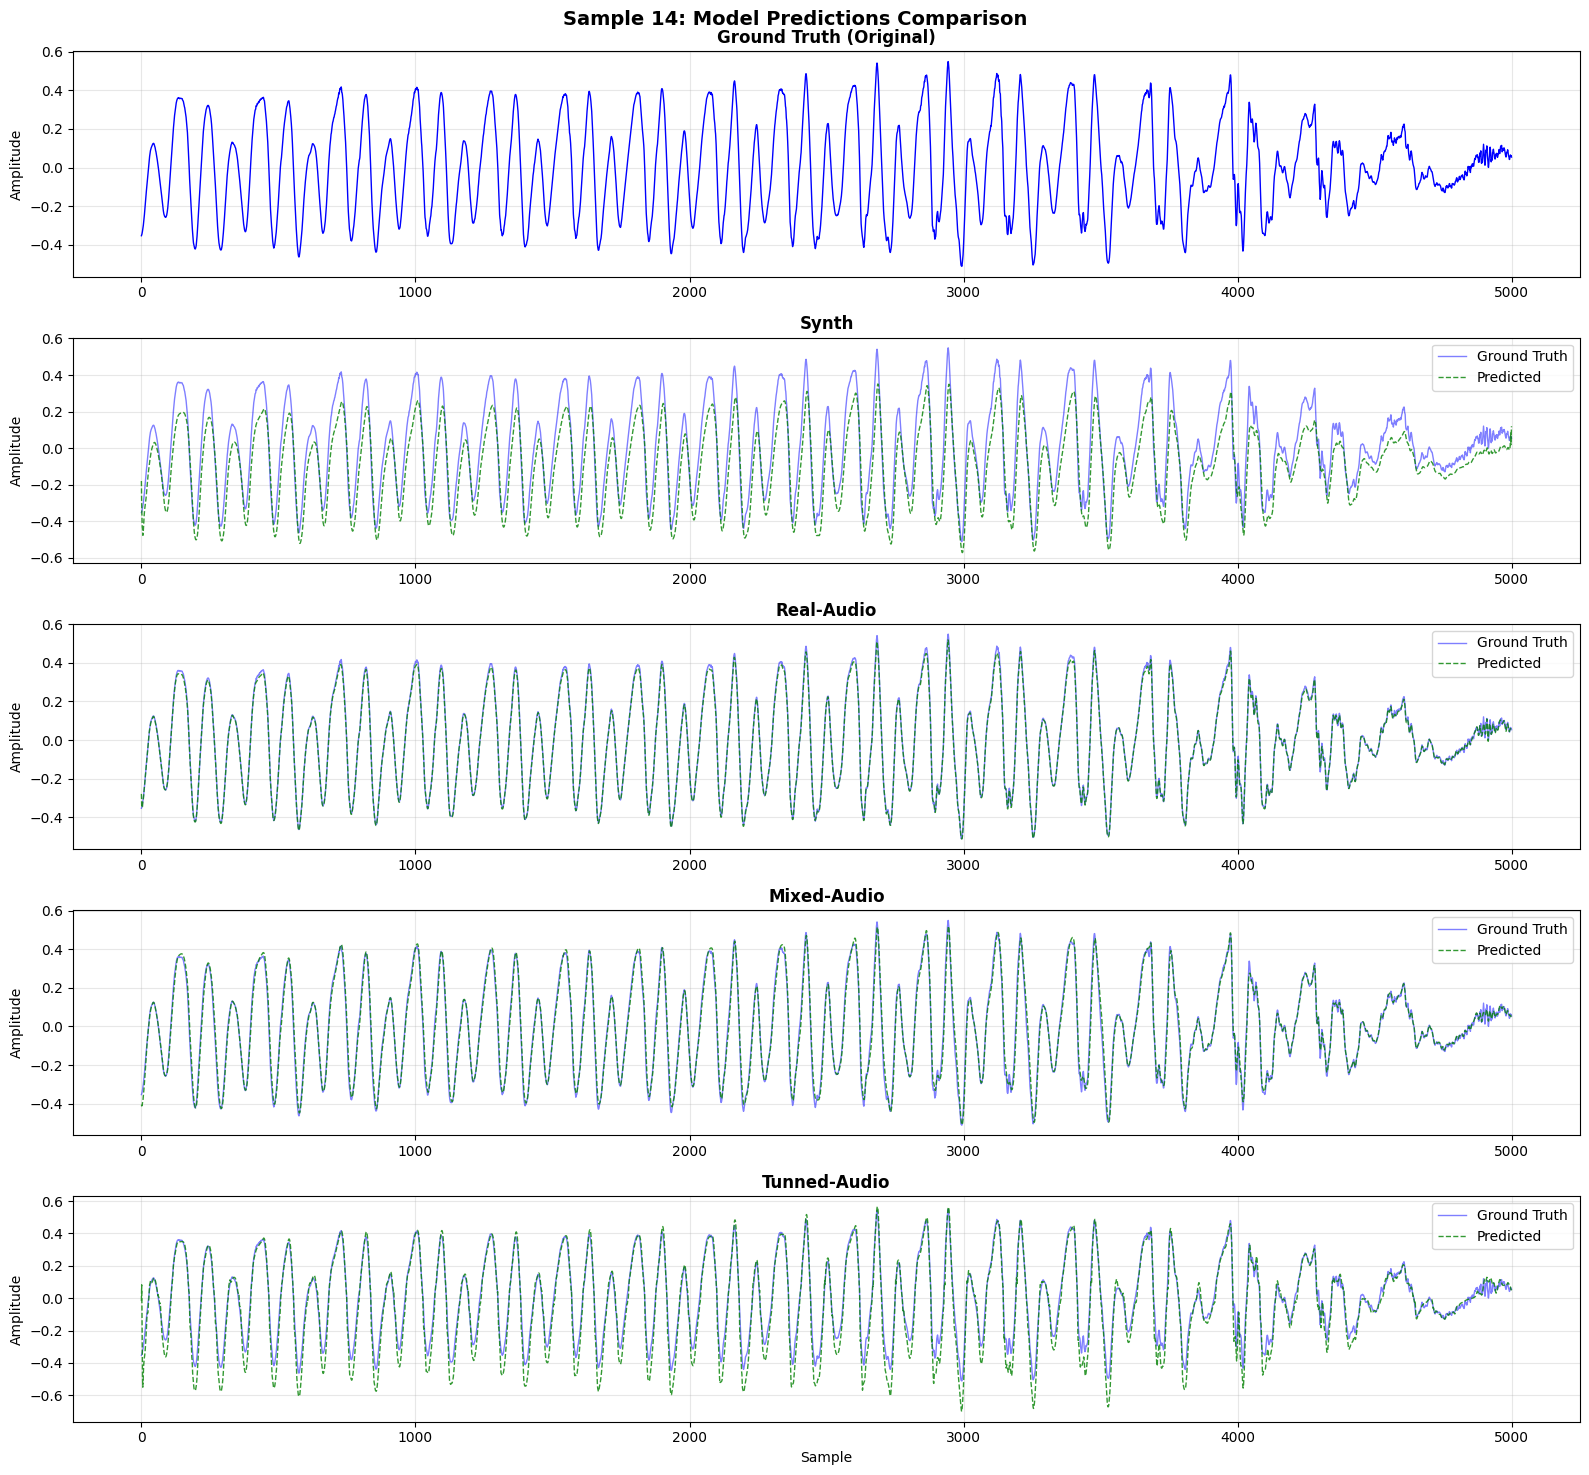

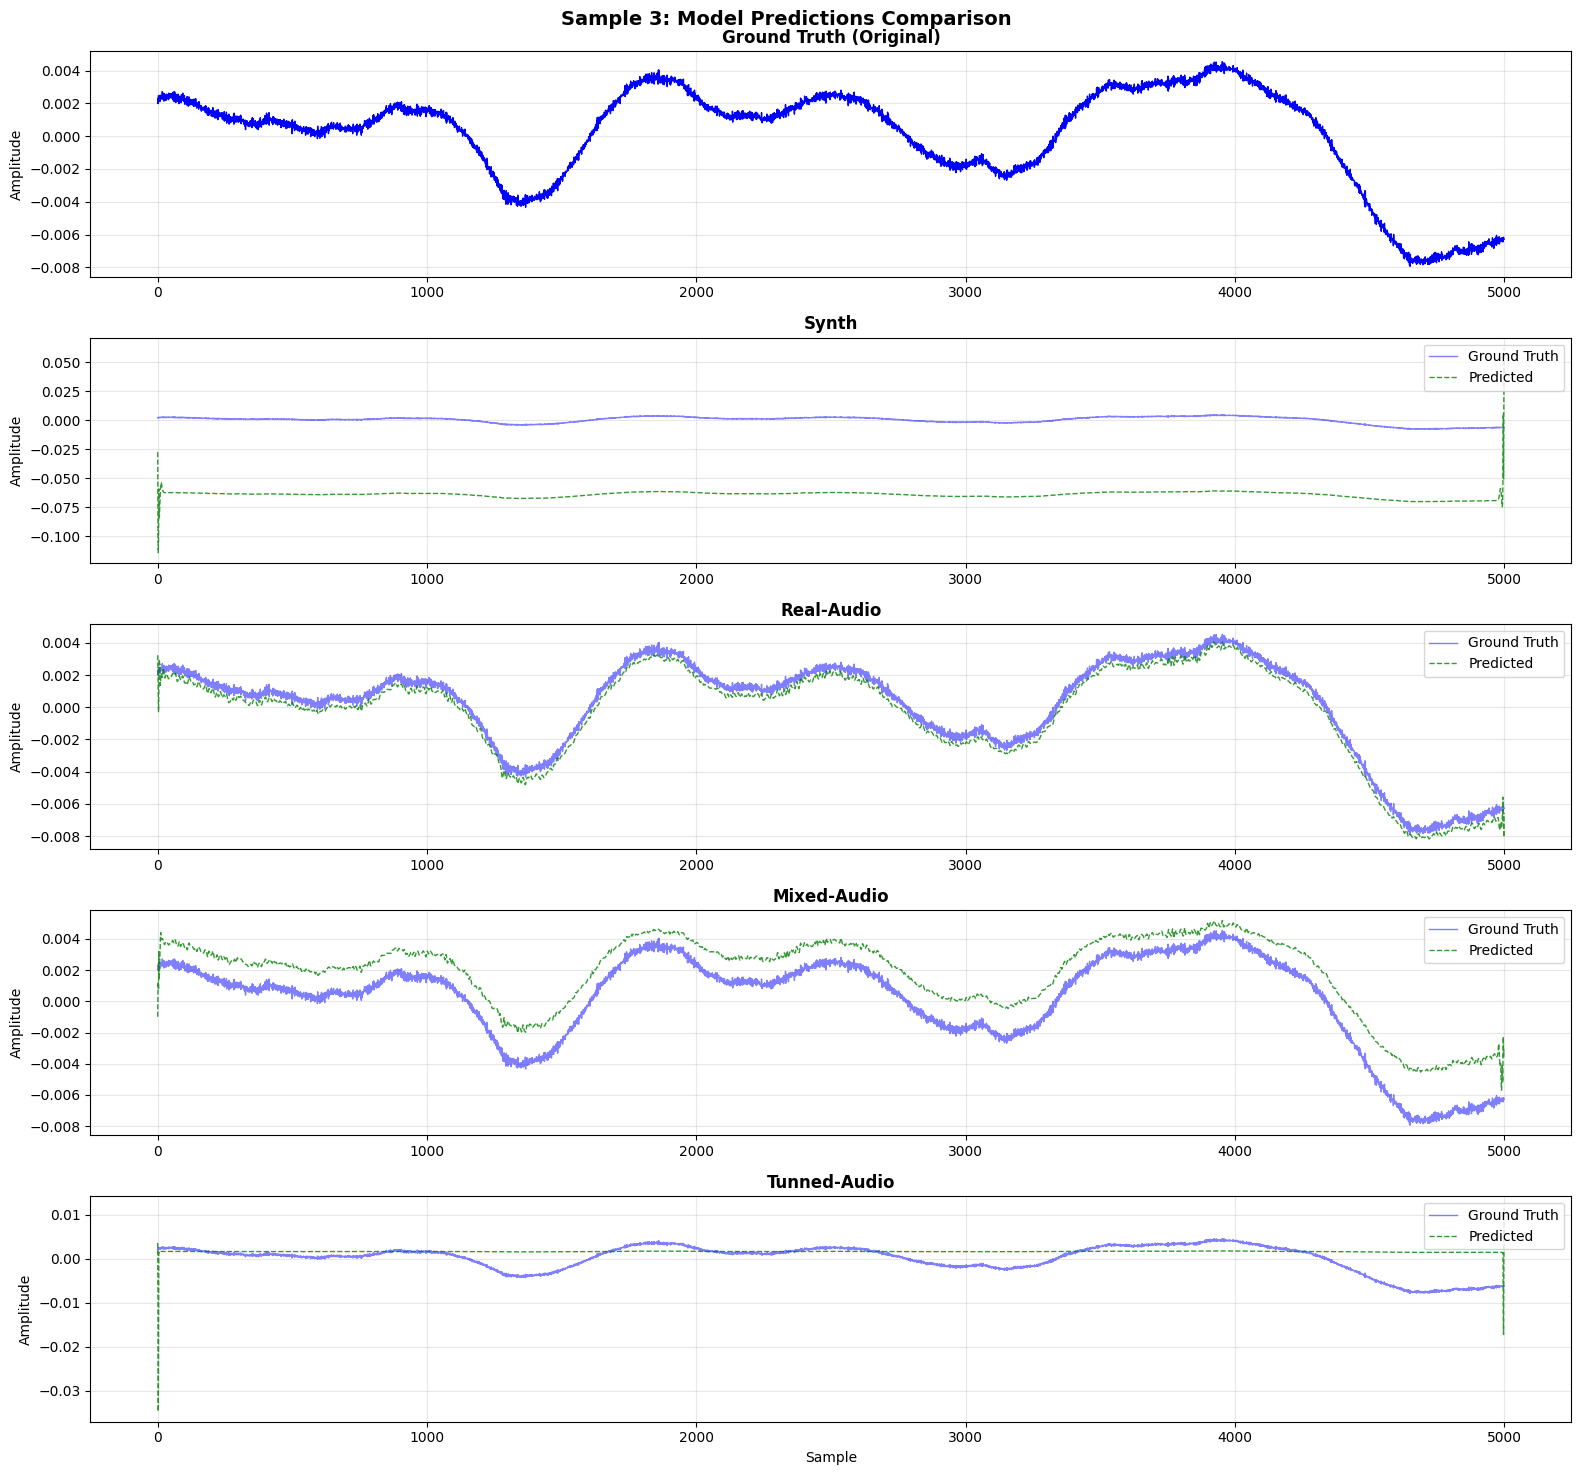

In [22]:
# Seleccionar muestras aleatorias para visualizar
random.seed(42)
sample_indices = random.sample(range(len(y_test)), 3)

for sample_idx in sample_indices:
    fig, axes = plt.subplots(len(models) + 1, 1, figsize=(16, 3 * (len(models) + 1)))
    
    # Ground truth
    axes[0].plot(y_test[sample_idx], 'b-', linewidth=1)
    axes[0].set_title('Ground Truth (Original)', fontweight='bold')
    axes[0].set_ylabel('Amplitude')
    axes[0].grid(True, alpha=0.3)
    
    # Predicciones de cada modelo
    for i, (name, y_pred) in enumerate(predictions.items()):
        axes[i + 1].plot(y_test[sample_idx], 'b-', linewidth=1, alpha=0.5, label='Ground Truth')
        axes[i + 1].plot(y_pred[sample_idx], 'g--', linewidth=1, alpha=0.8, label='Predicted')
        axes[i + 1].set_title(f'{name}', fontweight='bold')
        axes[i + 1].set_ylabel('Amplitude')
        axes[i + 1].legend(loc='upper right')
        axes[i + 1].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Sample')
    plt.suptitle(f'Sample {sample_idx}: Model Predictions Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 🔊 Step 11: Reconstrucción de Audio Completo

In [23]:
def downsample_direct(segment, target_samples):
    """Downsampling directo sin anti-aliasing."""
    x_original = np.linspace(0, 1, len(segment))
    x_target = np.linspace(0, 1, target_samples)
    interpolator = interp1d(x_original, segment, kind='linear')
    return interpolator(x_target)


def create_synthesis_window(chunk_size, overlap):
    """Crea ventana de síntesis para OLA."""
    window = np.ones(chunk_size)
    fade_length = overlap
    fade_in = 0.5 * (1 - np.cos(np.pi * np.arange(fade_length) / fade_length))
    fade_out = 0.5 * (1 + np.cos(np.pi * np.arange(fade_length) / fade_length))
    window[:fade_length] = fade_in
    window[-fade_length:] = fade_out
    return window


def reconstruct_audio(audio, model, device, chunk_size=5000, overlap=1000, input_size=1000):
    """
    Reconstruye audio completo usando OLA.
    """
    hop_size = chunk_size - overlap
    
    # Padding
    pad_start = overlap // 2
    n_chunks = int(np.ceil((len(audio) + pad_start) / hop_size))
    padded_length = pad_start + n_chunks * hop_size + (chunk_size - hop_size)
    pad_end = padded_length - len(audio) - pad_start
    y_padded = np.pad(audio, (pad_start, max(0, pad_end)), mode='reflect')
    
    # Segmentar y procesar
    chunks_reconstructed = []
    chunks_degraded = []
    positions = []
    
    start = 0
    while start + chunk_size <= len(y_padded):
        chunk = y_padded[start:start + chunk_size]
        
        # Degradar
        chunk_low = downsample_direct(chunk, input_size)
        
        # Reconstruir con modelo
        model.eval()
        with torch.no_grad():
            x = torch.tensor(chunk_low[np.newaxis, np.newaxis, :], dtype=torch.float32).to(device)
            chunk_rec = model(x).squeeze().cpu().numpy()
        
        chunks_reconstructed.append(chunk_rec)
        
        # Degradado (para comparación)
        x_high = np.linspace(0, 1, chunk_size)
        x_low = np.linspace(0, 1, input_size)
        chunks_degraded.append(interp1d(x_low, chunk_low, kind='linear')(x_high))
        
        positions.append(start)
        start += hop_size
    
    # OLA para recombinar
    window = create_synthesis_window(chunk_size, overlap)
    total_length = positions[-1] + chunk_size if positions else 0
    
    output_rec = np.zeros(total_length)
    output_deg = np.zeros(total_length)
    window_sum = np.zeros(total_length)
    
    for chunk_rec, chunk_deg, pos in zip(chunks_reconstructed, chunks_degraded, positions):
        end_pos = pos + chunk_size
        output_rec[pos:end_pos] += chunk_rec * window
        output_deg[pos:end_pos] += chunk_deg * window
        window_sum[pos:end_pos] += window
    
    # Normalizar
    valid_mask = window_sum > 1e-8
    output_rec[valid_mask] /= window_sum[valid_mask]
    output_deg[valid_mask] /= window_sum[valid_mask]
    
    # Recortar
    output_rec = output_rec[pad_start:pad_start + len(audio)]
    output_deg = output_deg[pad_start:pad_start + len(audio)]
    
    return output_deg, output_rec


print("✅ Funciones de reconstrucción de audio definidas")

✅ Funciones de reconstrucción de audio definidas


## 🔊 Step 12: Reconstruir Audio de Prueba con Cada Modelo

In [24]:
# Cargar un archivo de audio para prueba
AUDIO_DIR = Path("../../VCTK-Corpus/VCTK/Dataset_2Seg")
audio_files = sorted(list(AUDIO_DIR.glob("*.wav")))

# Seleccionar archivo de prueba
test_audio_path = audio_files[0]
print(f"🎵 Audio de prueba: {test_audio_path.name}")

# Cargar audio
original, sr = librosa.load(test_audio_path, sr=None)
print(f"   Duración: {len(original)/sr:.2f}s, SR: {sr} Hz")

🎵 Audio de prueba: p225_033.wav
   Duración: 2.00s, SR: 48000 Hz


In [25]:
# Reconstruir con cada modelo
reconstructions = {}
degraded = None

print("\n🔄 Reconstruyendo audio con cada modelo...")

for name, model in models.items():
    print(f"   Procesando {name}...")
    deg, rec = reconstruct_audio(original, model, device)
    reconstructions[name] = rec
    if degraded is None:
        degraded = deg

print("\n✅ Reconstrucción completada")


🔄 Reconstruyendo audio con cada modelo...
   Procesando Synth...
   Procesando Real-Audio...
   Procesando Mixed-Audio...
   Procesando Tunned-Audio...

✅ Reconstrucción completada


## 📊 Step 13: Métricas de Reconstrucción de Audio

In [26]:
def audio_metrics(original, reconstructed):
    """Calcula métricas para señales de audio."""
    min_len = min(len(original), len(reconstructed))
    orig = original[:min_len]
    rec = reconstructed[:min_len]
    
    mae = np.mean(np.abs(orig - rec))
    mse = np.mean((orig - rec)**2)
    corr, _ = pearsonr(orig, rec)
    
    # SNR
    signal_power = np.mean(orig**2)
    noise_power = np.mean((orig - rec)**2)
    snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
    
    return {'MAE': mae, 'MSE': mse, 'Correlation': corr, 'SNR (dB)': snr}


print("="*70)
print("MÉTRICAS DE RECONSTRUCCIÓN DE AUDIO")
print("="*70)

audio_results = {}

# Métricas de degradado
deg_metrics = audio_metrics(original, degraded)
print(f"\n📊 Degraded (interpolación lineal):")
print(f"   Correlation: {deg_metrics['Correlation']:.6f}")
print(f"   SNR: {deg_metrics['SNR (dB)']:.2f} dB")
audio_results['Degraded'] = deg_metrics

# Métricas de cada modelo
for name, rec in reconstructions.items():
    metrics = audio_metrics(original, rec)
    audio_results[name] = metrics
    print(f"\n📊 {name}:")
    print(f"   Correlation: {metrics['Correlation']:.6f}")
    print(f"   SNR: {metrics['SNR (dB)']:.2f} dB")

print("\n" + "="*70)

MÉTRICAS DE RECONSTRUCCIÓN DE AUDIO

📊 Degraded (interpolación lineal):
   Correlation: 0.992375
   SNR: 18.10 dB

📊 Synth:
   Correlation: 0.927175
   SNR: 2.78 dB

📊 Real-Audio:
   Correlation: 0.993631
   SNR: 18.75 dB

📊 Mixed-Audio:
   Correlation: 0.984063
   SNR: 14.97 dB

📊 Tunned-Audio:
   Correlation: 0.968230
   SNR: 9.60 dB



In [27]:
# Tabla de resultados de audio
df_audio = pd.DataFrame(audio_results).T.round(6)
print("\n📋 TABLA COMPARATIVA - RECONSTRUCCIÓN DE AUDIO")
print(df_audio.to_string())

# Guardar
df_audio.to_csv(OUTPUT_DIR / "audio_reconstruction_metrics.csv")
print(f"\n💾 Guardado en {OUTPUT_DIR / 'audio_reconstruction_metrics.csv'}")


📋 TABLA COMPARATIVA - RECONSTRUCCIÓN DE AUDIO
                   MAE       MSE  Correlation   SNR (dB)
Degraded      0.006128  0.000199     0.992375  18.104897
Synth         0.073306  0.006774     0.927175   2.780284
Real-Audio    0.006092  0.000171     0.993631  18.747758
Mixed-Audio   0.009274  0.000409     0.984063  14.973294
Tunned-Audio  0.021302  0.001408     0.968230   9.603240

💾 Guardado en ../results/audio_reconstruction_metrics.csv


## 🔊 Step 14: Reproducir Audios

In [28]:
print("🔊 Original:")
display(Audio(original, rate=sr))

print("\n🔊 Degraded (5x downsampled + interpolación):")
display(Audio(degraded, rate=sr))

🔊 Original:



🔊 Degraded (5x downsampled + interpolación):


In [29]:
# Reproducir reconstrucciones
for name, rec in reconstructions.items():
    print(f"\n🔊 Reconstruido - {name}:")
    display(Audio(rec, rate=sr))


🔊 Reconstruido - Synth:



🔊 Reconstruido - Real-Audio:



🔊 Reconstruido - Mixed-Audio:



🔊 Reconstruido - Tunned-Audio:


## 💾 Step 15: Guardar Audios Reconstruidos

In [30]:
# Guardar archivos de audio
audio_output_dir = OUTPUT_DIR / "audio_samples"
audio_output_dir.mkdir(exist_ok=True)

# Guardar degradado
sf.write(audio_output_dir / "degraded.wav", degraded, sr)
print(f"💾 Guardado: degraded.wav")

# Guardar reconstrucciones
for name, rec in reconstructions.items():
    filename = f"reconstructed_{name.lower().replace('-', '_')}.wav"
    sf.write(audio_output_dir / filename, rec, sr)
    print(f"💾 Guardado: {filename}")

print(f"\n📁 Todos los audios guardados en: {audio_output_dir}")

💾 Guardado: degraded.wav
💾 Guardado: reconstructed_synth.wav
💾 Guardado: reconstructed_real_audio.wav
💾 Guardado: reconstructed_mixed_audio.wav
💾 Guardado: reconstructed_tunned_audio.wav

📁 Todos los audios guardados en: ../results/audio_samples


## 📊 Step 16: Visualización de Formas de Onda

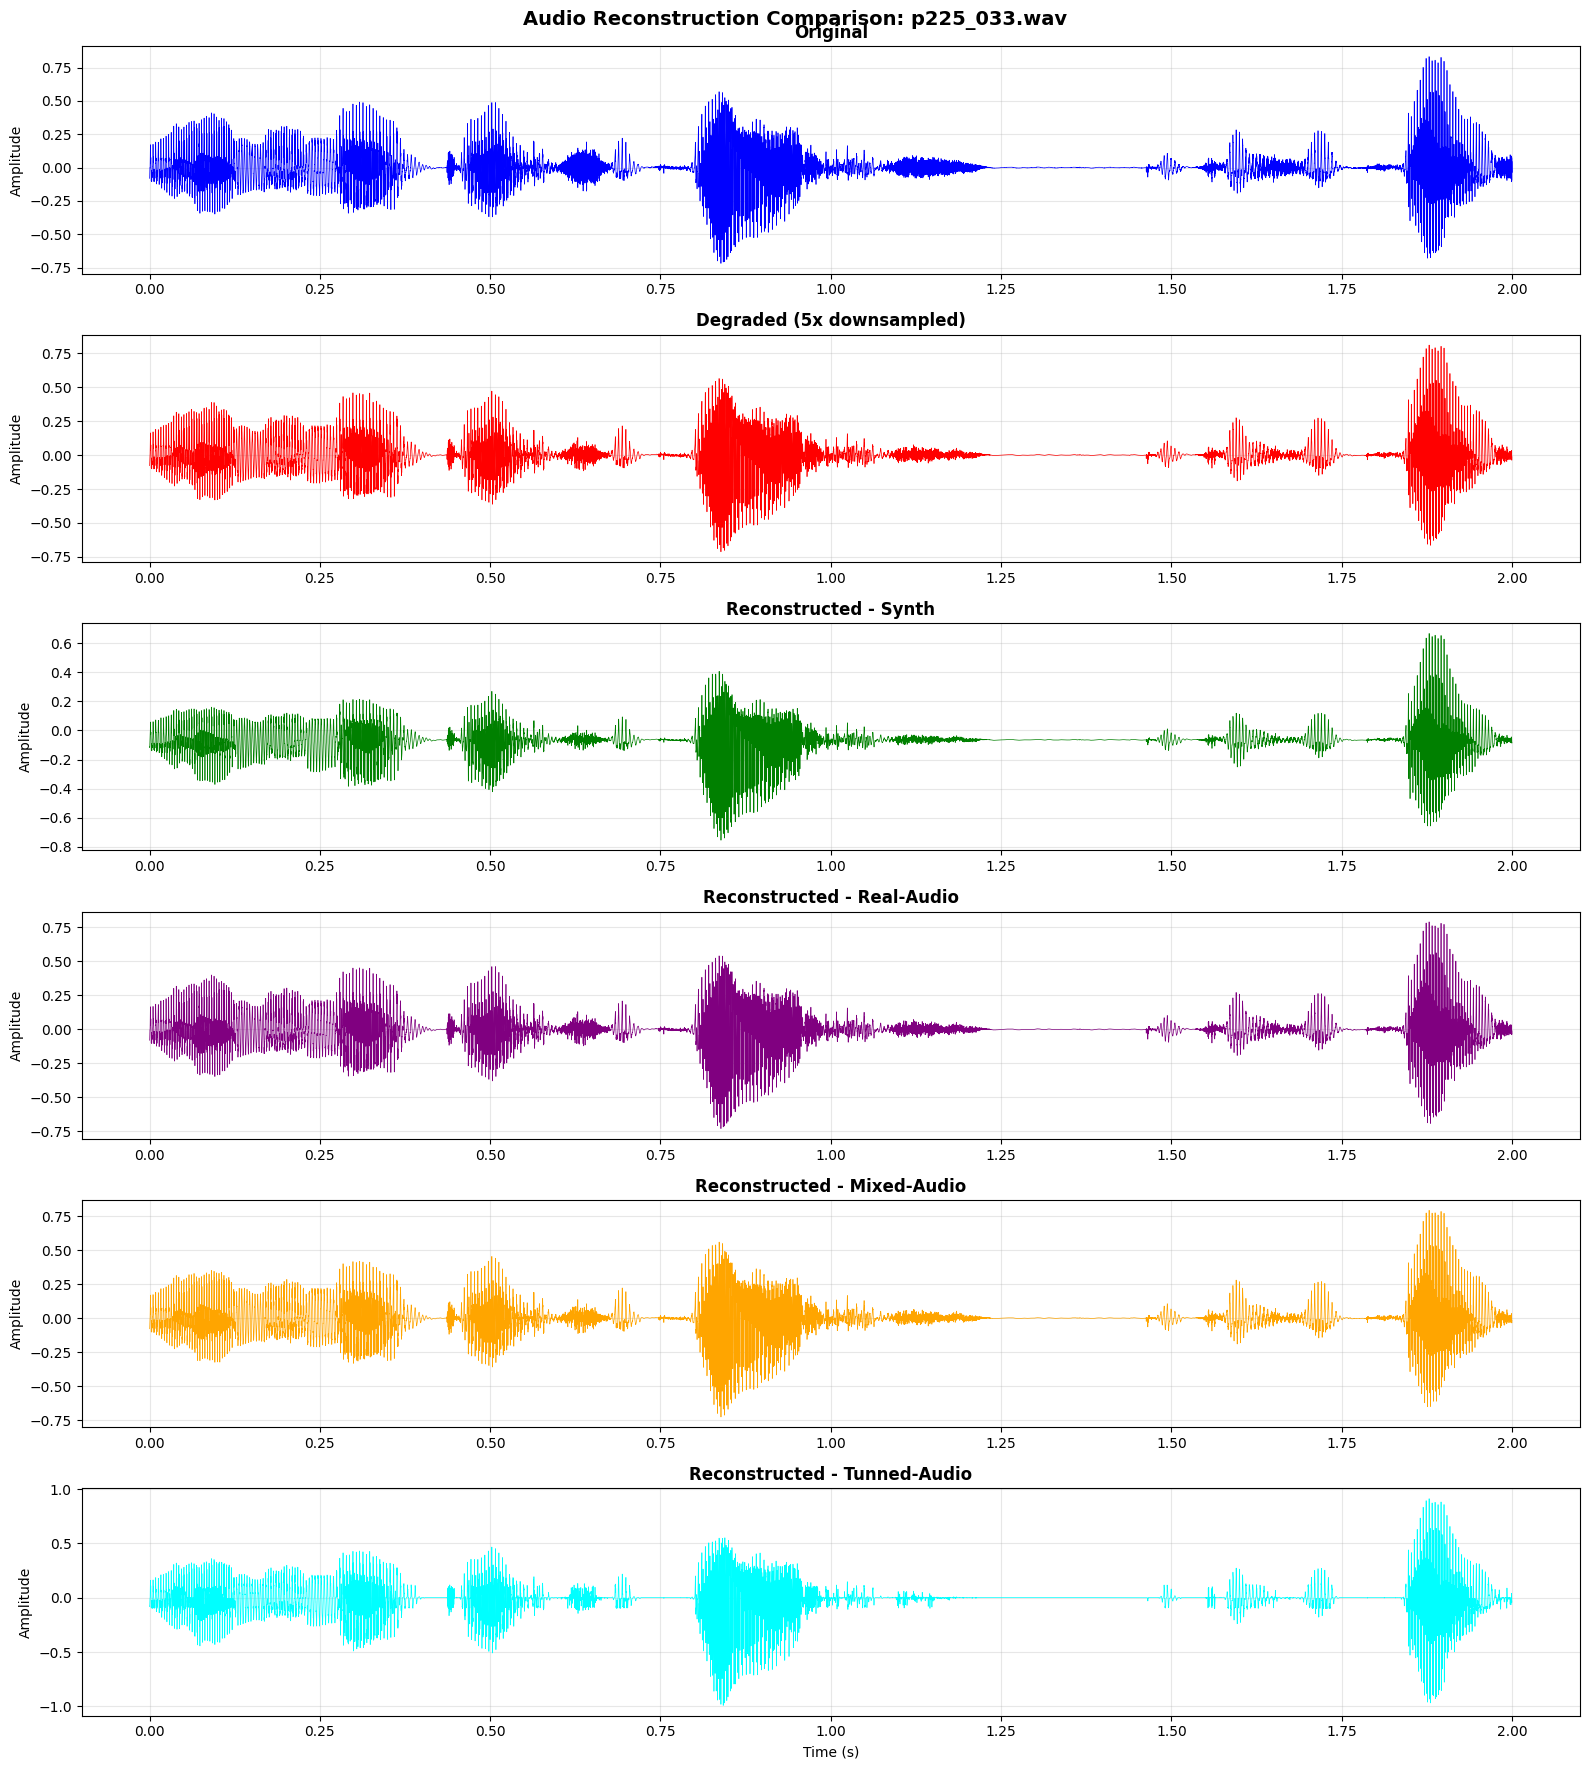


💾 Gráfico guardado en ../results/waveform_comparison.png


In [31]:
# Visualizar formas de onda
fig, axes = plt.subplots(len(reconstructions) + 2, 1, figsize=(16, 3 * (len(reconstructions) + 2)))

time = np.arange(len(original)) / sr

# Original
axes[0].plot(time, original, 'b-', linewidth=0.5)
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

# Degradado
time_deg = np.arange(len(degraded)) / sr
axes[1].plot(time_deg, degraded, 'r-', linewidth=0.5)
axes[1].set_title('Degraded (5x downsampled)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

# Reconstrucciones
colors = ['green', 'purple', 'orange', 'cyan']
for i, (name, rec) in enumerate(reconstructions.items()):
    time_rec = np.arange(len(rec)) / sr
    axes[i + 2].plot(time_rec, rec, color=colors[i % len(colors)], linewidth=0.5)
    axes[i + 2].set_title(f'Reconstructed - {name}', fontsize=12, fontweight='bold')
    axes[i + 2].set_ylabel('Amplitude')
    axes[i + 2].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time (s)')

plt.suptitle(f'Audio Reconstruction Comparison: {test_audio_path.name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "waveform_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Gráfico guardado en {OUTPUT_DIR / 'waveform_comparison.png'}")

## 📋 Step 17: Resumen Final

In [32]:
print("="*70)
print("📋 RESUMEN FINAL - EVALUACIÓN DE 4 MODELOS CON AUDIO")
print("="*70)

print("\n🎯 MÉTRICAS EN SEGMENTOS DE TEST:")
print(df_results.to_string())

print("\n🔊 MÉTRICAS EN RECONSTRUCCIÓN DE AUDIO COMPLETO:")
print(df_audio.to_string())

# Encontrar mejor modelo
best_corr = max(results.items(), key=lambda x: x[1]['Correlation'])
best_snr = max(results.items(), key=lambda x: x[1]['SNR (dB)'])
best_mae = min(results.items(), key=lambda x: x[1]['MAE'])

print(f"\n🏆 MEJOR MODELO POR MÉTRICA:")
print(f"   Mejor Correlación: {best_corr[0]} ({best_corr[1]['Correlation']:.6f})")
print(f"   Mejor SNR: {best_snr[0]} ({best_snr[1]['SNR (dB)']:.2f} dB)")
print(f"   Mejor MAE: {best_mae[0]} ({best_mae[1]['MAE']:.6f})")

print("\n" + "="*70)
print("✅ EVALUACIÓN COMPLETADA")
print("="*70)

📋 RESUMEN FINAL - EVALUACIÓN DE 4 MODELOS CON AUDIO

🎯 MÉTRICAS EN SEGMENTOS DE TEST:
                   MAE       MSE      RMSE  Correlation   SNR (dB)
Synth         0.067937  0.005232  0.072333     0.857009  -0.041811
Real-Audio    0.003972  0.000097  0.009857     0.956439  17.269658
Mixed-Audio   0.005023  0.000128  0.011324     0.948130  16.065212
Tunned-Audio  0.015231  0.000606  0.024626     0.757508   9.316930

🔊 MÉTRICAS EN RECONSTRUCCIÓN DE AUDIO COMPLETO:
                   MAE       MSE  Correlation   SNR (dB)
Degraded      0.006128  0.000199     0.992375  18.104897
Synth         0.073306  0.006774     0.927175   2.780284
Real-Audio    0.006092  0.000171     0.993631  18.747758
Mixed-Audio   0.009274  0.000409     0.984063  14.973294
Tunned-Audio  0.021302  0.001408     0.968230   9.603240

🏆 MEJOR MODELO POR MÉTRICA:
   Mejor Correlación: Real-Audio (0.956439)
   Mejor SNR: Real-Audio (17.27 dB)
   Mejor MAE: Real-Audio (0.003972)

✅ EVALUACIÓN COMPLETADA
